In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## Change these variables when running the notebook from a new location
# data_dir should be the directory of the zip files
# pickle_input should be the location of the 201516_ret.pickle file

root_dir = "/content/drive/My Drive/BVIA Group 4/"
data_dir = root_dir + "Data/"
pickle_input_201516 = root_dir + "Pickle/201516_ret.pickle"
pickle_input_201213 = root_dir + "Pickle/201213_ret.pickle"

# Week 4 - Picking Loans using Regression of Loan Returns

This notebook carries out the following steps
  1. Reads the saved pickle data. Re-run the classification models and check their stability over time
  2. Using only variables available at the time of loan application, predicts the returns on the loans
  3. Uses the regressions for returns and the classification models from before for implementimg some simple strategies for picking loans to invest in. 
  4. Tests these strategies on a portfolio of 100 loans
  5. Re-run the test strategies on different test and train sets from different time periods
  6. Performs a sensitivity analysis of the performance of the loan to the number of loans invested in from 100 to 1000

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import random
import plotly.express as px

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
## from gurobipy import *
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [ ]:
# read saved models after you have run some of the more time consuming ones and saved them
path = root_dir + "/saved_models/week4_saved_models"   
infile = open(path,'rb')
saved_models = pickle.load(infile)
models_to_save = saved_models.copy() # save new models in this new dict
infile.close()
print('models loaded:\n', saved_models.keys())

FileNotFoundError: ignored

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## 0.05 Downsample function

The following functions are used to downsample the loans to make them class-balance.

In [ ]:
def returnCounts(data):
  TCount = len(data)
  FCount = data.loan_status.str.contains('Fully Paid').sum()
  CCount = data.loan_status.str.contains('Charged Off').sum()
  DCount = data.loan_status.str.contains('Default').sum()
  DProp = 1-(FCount/TCount)

  print("Total count: %d" %(TCount))
  print("Fully Paid count: %d" %(FCount))
  print("Charged off count: %d" %(CCount))
  print("Default count: %d" %(DCount))
  print("Proportion of Charged off + Default: %.2f" %(DProp))
  return TCount, FCount, CCount, DCount, DProp

In [ ]:
def downsample(data, delProp = 0.7):
  dataCopy = data.copy()
  indexNames = dataCopy[dataCopy['loan_status'] == "Fully Paid" ].index #pull indexes of fully paid rows
  
  print("Before downsample:")
  TCount, FCount, CCount, DCount, DProp = returnCounts(dataCopy)

  delRowCount = int(delProp*FCount) 
  random.seed(4)
  dataCopy=dataCopy.drop(random.sample(set(indexNames), delRowCount)) #remove ~70% of the 'fully paid' entries

  print("\nAfter downsample:")
  TCount, FCount, CCount, DCount, DProp = returnCounts(dataCopy)

  return dataCopy

## 0.1 Load the data (2012-2013) and engineer the features

In [ ]:
# Read the data and features from the pickle
data12, discrete_features, continuous_features, ret_cols = pickle.load( open( pickle_input_201213, "rb" ) )

#data = data12.copy()
data = downsample(data12, delProp = 0.75)

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')


# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [ ]:
## STORE PROPORTION OF DEFAULT
train_default = 0.43
train_not_default = 0.57

actual_default = 0.16
actual_not_default = 0.84

## 0.2 Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that rowFdecisipn
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
    
    # Filter down the data to the required date range, and downsample
    # as required
#     print("sizes:", train.shape[0], data.shape[0], data_subset.shape[0])
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## 0.3 Models without grade or interest rate

In [ ]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)
selected_features12 = selected_features.copy()

In [ ]:
## Process data here:
data_dict12 = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = final_features)

### 0.3.1 Ridge Classifier

In [ ]:
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}
# cv_parameters = {"alpha":[0.0001]}
ridge_clf07 = fit_classification(RidgeClassifier(), data_dict12, 
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")

In [ ]:
models_to_save['ridge_clf07'] = ridge_clf07

### 0.3.2 Naive Bayes

In [ ]:
gnb07 = fit_classification(GaussianNB(), data_dict12,
                model_name = "Gaussian Naive Bayes")

In [ ]:
models_to_save['gnb07'] = gnb07

### 0.3.3 $l_1$ penalized logistic regression

In [ ]:
l1_logistic07 = saved_models['l1_logistic07']

In [ ]:
l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}
l1_logistic07 = fit_classification(l1_logistic, data_dict12,
                        cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

In [ ]:
models_to_save['l1_logistic07'] = l1_logistic07

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic07['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic07['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic07['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logisitic07')
plt.show()

### 0.3.4 $l_2$ penalized logistic regression

In [ ]:
l2_logistic07 = saved_models['l2_logistic07']

In [ ]:
# l2_logistic07 = LogisticRegression(penalty = 'l2')
# cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

# l2_logistic07 = fit_classification(l2_logistic, data_dict12,
#                         cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")

In [ ]:
models_to_save['l2_logistic07'] = l2_logistic07

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic07['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic07['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic07['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-0.1,0.1))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l2_logisitic07')
plt.show()

In [ ]:
coef_table = pd.DataFrame({"feature": selected_features[top_and_bottom_idx], "coeff": l2_logistic07['model'].coef_[0,top_and_bottom_idx]})
print(coef_table)

### 0.3.5 Decision tree

In [ ]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

dt07 = fit_classification(decision_tree, data_dict12, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

In [ ]:
models_to_save['dt07'] = dt07

In [ ]:
# Visualize the decision tree
# Zooming-in is allowed by double click
from sklearn.externals.six import StringIO 
import graphviz

dot_data = StringIO()
export_graphviz(dt07['model'], out_file=dot_data,  
                feature_names=selected_features,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Note that due to the fact that the number of 5-year loans is significantly smaller than that of 3-year loans, the decision tree model made the first split based on the loan term. To offset that effect, the rules we considered for the strategy in the next step included only split decisions made at second nodes forward

### ($\star$) 0.3.6 Random forest
Takes nearly 10 minutes given the large data set! So loading from saved output.

In [ ]:
# Read models saved in a dictionary
rf07 = saved_models['rf07']

In [ ]:
# random_forest = RandomForestClassifier()
# cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }

# rf07 = fit_classification(random_forest, data_dict12,
#                                    cv_parameters=cv_parameters, model_name="Random forest")

In [ ]:
#store the model
models_to_save['rf07'] = rf07

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf07['model'].feature_importances_)[-6:]) 
bplot = pd.Series(rf07['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.title('Most significant features of rf07')
plt.show()

In [ ]:
## A decision tree trained on the scores of random forest
trepin_tree = DecisionTreeClassifier(min_samples_leaf = 100, max_depth = 4)
trepin_tree.fit(rf07['y_pred_probs'].reshape(-1,1),data_dict12['y_test'])
dot_data = StringIO()
export_graphviz(trepin_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### ($\star$) 0.3.7 Bagged trees
Takes a very long time for the whole LC data set! So loading from saved output

In [ ]:
# Read models aved in a dictionary
bt07 = saved_models['bt07']

In [ ]:
# start = time.time()
# bt07 = RandomForestClassifier(max_features = 1.0)
# #cv_parameters = {'min_samples_leaf':[5, 10, 25, 50, 75, 100, 200], 'n_estimators': [60, 100, 150, 200, 300]}
# cv_parameters = {'min_samples_leaf':[50], 'n_estimators': [150]}


# bt07 = fit_classification(bt07, data_dict12,
#                                     cv_parameters=cv_parameters, model_name="Bagged trees")
# print("time elapsed",time.time()-start)

In [ ]:
models_to_save['bt07'] = bt07

### 0.3.8 Multi-layer perceptron

In [ ]:
# Read model saved in a dictionary
mlp07 = saved_models['mlp07']

In [ ]:
# mlp07 = MLPClassifier()
# cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

# mlp07 = fit_classification(mlp07, data_dict12,
#                          cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")

In [ ]:
models_to_save['mlp07'] = mlp07

# Step 1 - Time stability test of classifiers

### 1.1 On the time period 2015-2016

These models were already computed above on this data set. We will proceed to re-do them on data from a later time period.

### 1.1.2 Load 2015-2016 data

In [ ]:
data15, discrete_features, continuous_features, ret_cols = pickle.load( open( pickle_input_201516, "rb" ) )

#data = data13.copy()
data = downsample(data15, delProp = 0.70)

### Mimic what we did for the 2012-2013 data

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])


# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]


#data_dict = prepare_data(feature_subset = final_features)
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
# prepare data 
start_date_train = datetime.date(2015,1,1)
end_date_train = datetime.date(2015,9,1)
start_date_test = datetime.date(2015,10,1)
end_date_test = datetime.date(2015,12,1)

data_dict15 = prepare_data(data_subset = np.array([True]*np.array([True]*len(data))),
                              date_range_train = (start_date_train, end_date_train),
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 20000, n_samples_test = 10000, feature_subset = final_features)

## 1.2 Train on Q1-Q3 of 2015 and test on Q4 of 2015.
There are two intentions in looking for time stability.
- How do model performance based on 2012-13 data differ from those in a later time period, say trained from the first three quarters of 2015 and tested on the last quarter of 2015?
- The second intent is whether the top features of the same model (RF etc.) for 2012-13 were the same as those for 2015. 

We will see that the models trained across different time periods perform remarkably similar in terms of accuracy and other batch metrics, as well as 
having similar top features. 

### 1.2.1 Ridge Classifier

In [ ]:
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}

ridge_clf13 = fit_classification(RidgeClassifier(), data_dict15,
                   cv_parameters = cv_parameters, model_name = "Ridge Classfier", output_to_file = False)

In [ ]:
coef_table = pd.DataFrame({"feature": selected_features[top_and_bottom_idx], "coeff": ridge_clf13['model'].coef_[0,top_and_bottom_idx]})
print(coef_table)

In [ ]:
## Plot top 6 most significant features
temp = abs(ridge_clf13['model'].coef_[0])
top_idx = list(np.argsort(temp)[-6:]) # pick the highest 6 coef_ 
bplot = pd.Series(temp[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,10))
p2.set_xticklabels(xticks)
plt.title('Most significant features of ridge_clf13')
plt.show()

In [ ]:
## Plot top 6 most significant features
temp = abs(ridge_clf07['model'].coef_[0])
top_idx = list(np.argsort(temp)[-6:]) # pick the highest 6 coef_ 
bplot = pd.Series(temp[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,1))
p2.set_xticklabels(xticks)
plt.title('Most significant features of ridge_clf07')
plt.show()

### 1.2.2 Naive Bayes: time-based train-test split

In [ ]:
gnb13 = fit_classification(GaussianNB(), data_dict15,
                model_name = "Gaussian Naive Bayes")

In [ ]:
models_to_save['gnb13'] = gnb13

### 1.2.3 L1-regression

In [ ]:
l1 = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}
l1_logistic13 = fit_classification(l1, data_dict15,
                model_name = "l1 Penalized Logistic Regression")

In [ ]:
models_to_save['l1_logistic13'] = l1_logistic13

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic13['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic13['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic13['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logistic13')
plt.show()

In [ ]:
## for comparison, plot top 3 features with the most positive (and negative) weights for 2007 data
top_and_bottom_idx = list(np.argsort(l1_logistic07['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic07['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic07['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logisitic07')
plt.show()

### 1.2.4 L2-regression: time-based train-test split

In [ ]:
l2 = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}
l2_logistic13 = fit_classification(l2, data_dict15,
                model_name = "l2 Penalized Logistic Regression")

In [ ]:
models_to_save['l2_logistic13'] = l2_logistic13

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic13['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic13['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic13['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-2,2))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l2_logistic on 2015 data')
plt.show()

In [ ]:
## for comparison, plot top 3 features with the most positive (and negative) weights for 2012
top_and_bottom_idx = list(np.argsort(l2_logistic07['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic07['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic07['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-2,2))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l2_logisitic on 2012-13')
plt.show()

### 1.2.5 Decision tree: time-based train-test split

In [ ]:
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}
dt13 = fit_classification(decision_tree, data_dict15, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

In [ ]:
models_to_save['dt13'] = dt13

In [ ]:
# Visualize the decision tree
# Zooming-in is allowed by double click
from sklearn.externals.six import StringIO 
import graphviz

dot_data = StringIO()
export_graphviz(dt13['model'], 
                out_file=dot_data,  
                feature_names=selected_features,filled=True, 
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# For comparison from 2012
from sklearn.externals.six import StringIO 
import graphviz

dot_data = StringIO()
export_graphviz(dt07['model'], out_file=dot_data,  
                feature_names=selected_features12,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

FICO range high or low, annual income and dti appears on top splits in both models running on 12 and 15.

### ($\star$) 1.2.6 Random Forest.
Takes 10 minutes, so loading from memory

In [ ]:
# Load Saved Model  
rf13 = saved_models['rf13']

In [ ]:
# # Commands used to generate rf13:
# cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }

# rf13 = fit_classification(RandomForestClassifier(), data_dict15,
#                                    cv_parameters=cv_parameters, model_name="Random forest")

In [ ]:
models_to_save['rf13'] = rf13

###  1.2.7 Multi Layer Perceptron

In [ ]:
# Read model saved in a dictionary
mlp13 = saved_models['mlp13']

In [ ]:
# mlp13 = MLPClassifier()
# cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

# mlp13 = fit_classification(mlp13, data_dict15,
#                          cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")

In [ ]:
models_to_save['mlp13'] = mlp13

In [ ]:
models_to_save.keys()

### Comparison: Random forest run - 2012-13 vs 2015
We see that the 3 of the top 6 features are the same.

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf07['model'].feature_importances_)[-6:]) 
bplot = pd.Series(rf07['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.title('Most significant features of RF run on 2012-13')
plt.show()

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf13['model'].feature_importances_)[-6:]) 
bplot = pd.Series(rf13['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.title('Most significant features of RF run on 2015')
plt.show()

# 2. Build and Test Regression Models for returns

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc', 'ret_Hybrid']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        #y_train = data.loc[filter_train, ret_col].as_matrix()
        #y_test = data.loc[filter_test, ret_col].as_matrix()
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:", )
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0 (non-default):", test_scores['model_0'])
                print("model_1 (default):", test_scores['model_1'])
                print('Avg Predicted regular return:', np.sum(predicted_regular_return)/len(predicted_regular_return))
                print('Avg Predicted default return:', np.sum(predicted_default_return)/len(predicted_default_return))

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])
                print("Avg Predcited return:", np.sum(predicted_return)/len(predicted_return))

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

## 2.1 Test regression models on 2012-2013 data
Unlike prevous week on classification models, we decided to apply regressors on full dataset. 

## For All Returns

In [ ]:
# Read the data and features from the pickle
data12, discrete_features, continuous_features, ret_cols = pickle.load( open( pickle_input_201213, "rb" ) )

#data = data12.copy()
data = downsample(data12, delProp = 0.75)

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')


# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [ ]:
final_features = [i for i in discrete_features + continuous_features if i not in ["installment"]]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)
selected_features12 = selected_features.copy()

## Process data here:
data_dict12 = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = final_features)

### 2.1.1 Lasso-Lars regressor

In [ ]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso07 = fit_regression(linear_model.LassoLars(), data_dict12, 
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

### 2.1.2 Ridge regressor

In [ ]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge07 = fit_regression(linear_model.Ridge(), data_dict12,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

### 2.1.3 Ordinary least squares

In [ ]:
reg_linear12 = fit_regression(linear_model.LinearRegression(), data_dict12,
               separate = False, model_name = "Linear Regression")

### ($\star$) 2.1.4 Multi-layer perceptron regressor

In [ ]:
# you may skip the computation by running:
reg_mlp12 = saved_models['reg_mlp12'] 
reg_mlp12

In [ ]:
# cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
#                   'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

# reg_mlp12 = fit_regression(MLPRegressor(), data_dict12,
#                cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

### ($\star$) 2.1.5 Random forest regressor

In [ ]:
# you may skip the computation by running:
reg_rf12 = saved_models['reg_rf12'] 
reg_rf12

In [ ]:
# cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
#                  'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

# reg_rf07 = fit_regression(RandomForestRegressor(), data_dict07,
#                cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

## For Defaulted Loans & Nondefaulted Loans


### 2.1.1 Lasso-Lars regressor

In [ ]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso07 = fit_regression(linear_model.LassoLars(), data_dict12, 
               cv_parameters = cv_parameters, separate = True, model_name = "Lasso")

### 2.1.2 Ridge regressor

In [ ]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge07 = fit_regression(linear_model.Ridge(), data_dict12,
               cv_parameters = cv_parameters, separate = True, model_name = "Ridge")

### 2.1.3 Ordinary least squares

In [ ]:
reg_linear07 = fit_regression(linear_model.LinearRegression(), data_dict12,
               separate = True, model_name = "Linear Regression")

### ($\star$) 2.1.4 Multi-layer perceptron regressor

In [ ]:
# you may skip the computation by running:
reg_mlp12_df = saved_models['reg_mlp12_df'] 
reg_mlp12_df

In [ ]:
# cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
#                   'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

# reg_mlp12 = fit_regression(MLPRegressor(), data_dict12,
#                cv_parameters = cv_parameters, separate = True, model_name = "Multi-Layer Perceptron")

### ($\star$) 2.1.5 Random forest regressor

In [ ]:
# you may skip the computation by running:
reg_rf12_df = saved_models['reg_rf12_df']
reg_rf12_df

In [ ]:
# cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
#                  'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

# reg_rf12 = fit_regression(RandomForestRegressor(), data_dict07,
#                cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor")

## 2.2 Test on 2015-2016 data

Testing same regressors on dataset in different periods to test out the time stability. The result shows that 2012-2013 has a slightly better r2 scores than 2015-2016

## For All Returns

In [ ]:
data15, discrete_features, continuous_features, ret_cols = pickle.load( open( pickle_input_201516, "rb" ) )

#data = data13.copy()
data = downsample(data15, delProp = 0.70)

### Mimic what we did for the 2012-2013 data

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])


# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]


#data_dict = prepare_data(feature_subset = final_features)
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
# prepare data 
start_date_train = datetime.date(2015,1,1)
end_date_train = datetime.date(2015,9,1)
start_date_test = datetime.date(2015,10,1)
end_date_test = datetime.date(2015,12,1)

data_dict15 = prepare_data(data_subset = np.array([True]*np.array([True]*len(data))),
                              date_range_train = (start_date_train, end_date_train),
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 20000, n_samples_test = 10000, feature_subset = final_features)

### 2.2.1 Lasso-LARS regressor 

In [ ]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso13 = fit_regression(linear_model.LassoLars(), data_dict15,
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

### 2.2.2 Ridge regressor

In [ ]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge13 = fit_regression(linear_model.Ridge(), data_dict15,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

### 2.2.3 Ordinary Least Squares

In [ ]:
reg_linear13 = fit_regression(linear_model.LinearRegression(), data_dict15,
               separate = False, model_name = "Linear Regression")

###  2.2.4 ($\star$) Multi-layer perceptron regressor

In [ ]:
# you may skip the computation by running:
reg_mlp15 = saved_models['reg_mlp15']
reg_mlp15

In [ ]:
# cv_parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
#                   'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

# reg_mlp15 = fit_regression(MLPRegressor(), data_dict15,
#                cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

###  2.2.5 ($\star$) Random forest regressor

In [ ]:
# you may skip the computation by running:
reg_rf15 = saved_models['reg_rf15'] 
reg_rf15

In [ ]:
# cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
#                  'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

# reg_rf15 = fit_regression(RandomForestRegressor(), data_dict15,
#                cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

## For Defaulted Loans & Nondefaulted Loans


### 2.2.1 Lasso-LARS regressor 

In [ ]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso13 = fit_regression(linear_model.LassoLars(), data_dict15,
               cv_parameters = cv_parameters, separate = True, model_name = "Lasso")

### 2.1.2 Ridge regressor

In [ ]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge13 = fit_regression(linear_model.Ridge(), data_dict15,
               cv_parameters = cv_parameters, separate = True, model_name = "Ridge")

### 2.2.3 Ordinary Least Squares

In [ ]:
reg_linear15 = fit_regression(linear_model.LinearRegression(), data_dict15,
               separate = True, model_name = "Linear Regression")

###  2.2.4 ($\star$) Multi-layer perceptron regressor

In [ ]:
# you may skip the computation by running:
reg_mlp15_df = saved_models['reg_mlp15_df']
reg_mlp15_df

###  2.2.5 ($\star$) Random forest regressor

In [ ]:
# you may skip the computation by running:
reg_rf15_df = saved_models['reg_rf15_df']
reg_rf15_df

# Step 3 - Test investment strategies
Now we test several investment strategies using the learning models above.

*Note - we added our additional return columns to the below function, as well as the following strategies:*

*   Best possible: For benchmarking purposes only. Return the average of the top n loans.
*   Tree-based: Pick top two rules from decision tree models built last week. Use those rules to determine top loans. This model is explained in more detail in this week's report.



In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
      - tree-based: pick top (quantified by largest cut) 2 rules  out by decision trees
                    model output from last week run. Filter the test loans for those rules and 
                    invest out of those filtered loans. Then, calculate the average return.

    It expects the following parameters
      - data: the data set we are using now
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == "Best Possible":
 
            # Sort the loans by ACTUAL return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)
            
            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score

        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Tree-based':
            # Define rules based on optimal tree nodes
            # FICO RANGE HIGH > 0.363 AND ANNUAL_INC > 0.448
            rule_1 = (data_test['fico_range_high'] > 0.363) & (data_test['annual_inc'] > 0.448) 
            # OR: FICO_RANGE_HIGH < 0.228 AND DTI < 0.358
            rule_2 = (data_test['fico_range_high'] < 0.228) & (data_test['dti'] < 0.358) 
            # Filter for loans to pick
            pf_test = data_test.loc[(rule_1) | (rule_2)]
            # Pick num_loans loans, if num_loans exceed available loans, return 'num_loans exceed loan availability'
            if num_loans <= len(pf_test):
              pf_test = pf_test.iloc[:num_loans]
              ret_test = np.mean(pf_test[ret_col])
            else:
              ret_test = 'num_loans exceed loan availability'
            # Returns
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}
            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )
            continue


        else:
            return 'Not a valid strategy'

    return out

# Step 4 - Implement the test strategies on 2012-2013 data

## 4.01 Re-load full 2012-13 dataset

Load in the full 2012/13 dataset again for strategy testing. Recall the dataset was downsampled earlier for classifier model training. We will re-split into train/test sets with the true balance of default vs. non-default.

In [ ]:
data = data12.copy()

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)
selected_features12 = selected_features.copy()

## Process data here:
data_dict12_strat = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = final_features)

## 4.02 Predict probability of default and return on the test data

Since we are using the full (not downsampled) dataset to test strategies, we need to run our trained models (read from the saved model file) on the full dataset to obtain predictions.

We also need to transform the score predictions for the classifier model, due to the sample change from training to strategy testing.

In [ ]:
# Choose the default classifier
default_classifier = saved_models['l1_logistic07'].copy()

# Choose the return regressor
return_regressor = saved_models['reg_rf12'].copy()

# Choose the separate return regressor
return_regressor_separate = saved_models['reg_rf12_df'].copy()

In [ ]:
## Adjust default probability
probs = default_classifier['model'].predict_proba(data_dict12_strat['X_test'])[:,1]

actual_default = sum(data_dict12_strat['y_test'])/len(data_dict12_strat['y_test'])
actual_not_default = 1 - actual_default

print("Adjusting classifier for new default split. % Default:",actual_default)

A = probs/(train_default/actual_default)
B = (1 - probs)/(train_not_default/actual_not_default)
new_p = A/(A+B)
default_classifier['y_pred_probs'] = new_p

Adjusting classifier for new default split. % Default: 0.1582


In [ ]:
## Predict return for Return-based strategy
for ret_col in return_regressor.keys():
  return_regressor[ret_col]['predicted_return'] = return_regressor[ret_col]['model'].predict(data_dict12_strat['X_test'])

In [ ]:
## Predict return for Two-stage strategy
for ret_col in return_regressor_separate.keys():
  return_regressor_separate[ret_col]['predicted_regular_return'] = return_regressor_separate[ret_col]['model_0'].predict(data_dict12_strat['X_test'])
  return_regressor_separate[ret_col]['predicted_default_return'] = return_regressor_separate[ret_col]['model_1'].predict(data_dict12_strat['X_test'])

## 4.1 Random  <a name='sec4.1'/>
Compare with <a href=#sec5.1> section 5.1</a>: random rule on 2015-16 data

In [ ]:
strategy_results_12 = {}

In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict12_strat, strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy_results_12[test_strategy] = strat_random

strategy: Random
ret_PESS: 0.028134580284846333
ret_OPT: 0.062012807044345655
ret_INTa: 0.042668948849952315
ret_INTb: 0.04933754530764588
ret_INTc: 0.09336684645216911
ret_Hybrid: 0.06876063211004313


## 4.2 Ranking   <a name='sec4.2'/>
Compare with <a href=#sec5.2> section 5.2</a>.

In [ ]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict12_strat, classifier=default_classifier, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy_results_12[test_strategy] = strat_rank

strategy: Ranking
ret_PESS: 0.025544841488884293
ret_OPT: 0.05827973005642629
ret_INTa: 0.024588527408662107
ret_INTb: 0.05251624513086491
ret_INTc: 0.07802492794807546
ret_Hybrid: 0.08400469238965051


## 4.3 Regression    <a name='sec4.3'/>
Compare with <a href=#sec5.3> section 5.3</a>.

In [ ]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict12_strat, regressor = return_regressor, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy_results_12[test_strategy] = strat_reg

strategy: Regression
ret_PESS: 0.05833417378070244
ret_OPT: 0.07641893317356119
ret_INTa: 0.041181780747910054
ret_INTb: 0.0543015383177116
ret_INTc: 0.09406652707105648
ret_Hybrid: 0.07939607153786607


## 4.4 Two Stage on 2012-2013 data  <a name='sec4.4'/>
Compare with <a href=#sec5.4> section 5.4</a>.

In [ ]:
# Test with score adjustment
test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict12_strat, classifier = default_classifier, regressor = return_regressor_separate, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy_results_12[test_strategy] = two_stage

strategy: Two-stage
ret_PESS: 0.07782948706261758
ret_OPT: 0.08090653738800299
ret_INTa: 0.04304298697600049
ret_INTb: 0.046935009779937725
ret_INTc: 0.09384203613831926
ret_Hybrid: 0.07989612938912062


## 4.5 Best Possible

For benchmarking purposes only

In [ ]:
## Best Possible Strategy
# Test with score adjustment
test_strategy = 'Best Possible'

print('strategy:',test_strategy)
best_possible = test_investments(data_dict12_strat,
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(best_possible[ret_col]['average return']))

strategy_results_12[test_strategy] = best_possible

strategy: Best Possible
ret_PESS: 0.14028712573194443
ret_OPT: 0.2252569619657012
ret_INTa: 0.1504809288190356
ret_INTb: 0.16764774012670441
ret_INTc: 0.19952427409743012
ret_Hybrid: 0.2179708407450863


## 4.6 Rules Based on Decision Tree Output

In [ ]:
test_strategy = 'Tree-based'

print('strategy: ', test_strategy)
tree_based = test_investments(data_dict12_strat, classifier = default_classifier,
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(tree_based[ret_col]['average return']))

strategy_results_12[test_strategy] = tree_based

strategy:  Tree-based
ret_PESS: 0.04377432220305408
ret_OPT: 0.06743952160238469
ret_INTa: 0.04015317685245277
ret_INTb: 0.056641506809918356
ret_INTc: 0.08680968252975639
ret_Hybrid: 0.07893672778667865


## Strategy Results (2012)

In [ ]:
strategy_results_list = []
for s in strategy_results_12.keys():
  for ret_col in col_list:
    strategy_results_list.append([s, ret_col, (strategy_results_12[s][ret_col]['average return'])])
strategy_results12_df = pd.DataFrame(strategy_results_list, columns=['Strategy','Return Column','Avg Return'])
strategy_results12_df.sort_values(by=['Return Column','Strategy'], inplace=True)
print(strategy_results12_df)

         Strategy Return Column  Avg Return
29  Best Possible    ret_Hybrid    0.217971
5          Random    ret_Hybrid    0.068761
11        Ranking    ret_Hybrid    0.084005
17     Regression    ret_Hybrid    0.079396
35     Tree-based    ret_Hybrid    0.078937
23      Two-stage    ret_Hybrid    0.079896
26  Best Possible      ret_INTa    0.150481
2          Random      ret_INTa    0.042669
8         Ranking      ret_INTa    0.024589
14     Regression      ret_INTa    0.041182
32     Tree-based      ret_INTa    0.040153
20      Two-stage      ret_INTa    0.043043
27  Best Possible      ret_INTb    0.167648
3          Random      ret_INTb    0.049338
9         Ranking      ret_INTb    0.052516
15     Regression      ret_INTb    0.054302
33     Tree-based      ret_INTb    0.056642
21      Two-stage      ret_INTb    0.046935
28  Best Possible      ret_INTc    0.199524
4          Random      ret_INTc    0.093367
10        Ranking      ret_INTc    0.078025
16     Regression      ret_INTc 

In [ ]:
fig = px.bar(strategy_results12_df, x="Return Column", y="Avg Return",
             color='Strategy', barmode='group',
             height=400,title="2012 Strategy Results")
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

## Time Sensitivity (2012) (step 6)

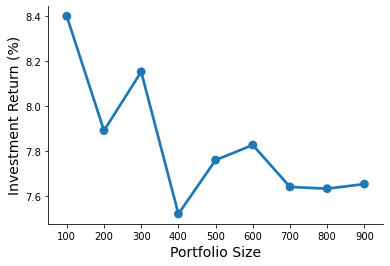

In [ ]:
result_sensitivity = []

## Vary the portfolio size from 100 to 1000
# random_forest = rf07
for num_loans in list(range(100,1000,100)):
    reg_0 = test_investments(data_dict12_strat, regressor = return_regressor_separate, classifier = default_classifier, 
                            strategy = 'Ranking', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_Hybrid']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(100,1000,100))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()

# Hybrid + Two-Stage - good chart
# Also show Hyrbid + Best Possible

# Step 5- Sensitivity of the strategies across times

Again, we downsampled the 2015 set earlier to make the default/non-default class balance, so we must re-build the 2015 dataset with the actual default/non-default split.

We also must again run our models on this new dataset to obtain predictions, and adjust for class imbalance where necessary.

In [ ]:
## switch back to 2015-16 data
data = data15.copy()

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)
selected_features15 = selected_features.copy()

## Process data here:
# prepare data 
start_date_train = datetime.date(2015,1,1)
end_date_train = datetime.date(2015,9,1)
start_date_test = datetime.date(2015,10,1)
end_date_test = datetime.date(2015,12,1)

data_dict15_strat = prepare_data(data_subset = np.array([True]*np.array([True]*len(data))),
                              date_range_train = (start_date_train, end_date_train),
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 20000, n_samples_test = 10000, feature_subset = final_features)

In [ ]:
# Choose the default classifier
default_classifier15 = saved_models['l1_logistic07'].copy()

# Choose the return regressor
return_regressor15 = saved_models['reg_rf12'].copy()

## Choose the split return regressor
return_regressor_separate15 = saved_models['reg_rf12_df'].copy()

In [ ]:
## Adjust for class balance change
probs = default_classifier15['model'].predict_proba(data_dict15_strat['X_test'])[:,1]

actual_default = sum(data_dict15_strat['y_test'])/len(data_dict15_strat['y_test'])
actual_not_default = 1 - actual_default

A = probs/(train_default/actual_default)
B = (1 - probs)/(train_not_default/actual_not_default)
new_p = A/(A+B)
default_classifier15['y_pred_probs'] = new_p

In [ ]:
## Predict return for Return-based strategy
for ret_col in return_regressor15.keys():
  return_regressor15[ret_col]['predicted_return'] = return_regressor[ret_col]['model'].predict(data_dict15_strat['X_test'])

In [ ]:
## Predict return for two-stage strategy
for ret_col in return_regressor_separate15.keys():
  return_regressor_separate15[ret_col]['predicted_regular_return'] = return_regressor_separate15[ret_col]['model_0'].predict(data_dict15_strat['X_test'])
  return_regressor_separate15[ret_col]['predicted_default_return'] = return_regressor_separate15[ret_col]['model_1'].predict(data_dict15_strat['X_test'])

### 5.1 Random <a name = 'sec5.1' />
Compare with <a href=#sec4.1>section 4.1</a>: random rule applied on 2012-2013 data

In [ ]:
strategy_results_15 = {}

In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict15_strat, strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy_results_15[test_strategy] = strat_random

strategy: Random
ret_PESS: 0.014995600816745315
ret_OPT: 0.05358572908874967
ret_INTa: 0.02207658613416822
ret_INTb: 0.03088410279834291
ret_INTc: 0.05823993500173976
ret_Hybrid: 0.06306924501922306


### 5.2 Ranking  <a name = 'sec5.2' />
Compare with <a href=#sec4.2>section 4.2</a>: ranking applied on 2012-2013 data

In [ ]:
# load the random forest model if you haven't yet
# rf07 = saved_models['rf07']

test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict15_strat, classifier=default_classifier15, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy_results_15[test_strategy] = strat_rank

strategy: Ranking
ret_PESS: 0.019710812719464208
ret_OPT: 0.035489050568630685
ret_INTa: 0.021778703249817333
ret_INTb: 0.020316179744942885
ret_INTc: 0.06673755757159328
ret_Hybrid: 0.05951975552741091


### 5.3 Regression  <a name = 'sec5.3' />
Compare with <a href=#sec4.3>section 4.3</a>: regression rule applied on 2012-2013 data

In [ ]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict15_strat, regressor = return_regressor15, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy_results_15[test_strategy] = strat_reg

strategy: Regression
ret_PESS: 0.018459049696727917
ret_OPT: 0.039150044936557826
ret_INTa: 0.020601831916734547
ret_INTb: 0.026669780656008498
ret_INTc: 0.062488565964642376
ret_Hybrid: 0.052454585494394614


### 5.4 Two-stage  <a name = 'sec5.4' />
Compare with <a href=#sec4.4>section 4.4</a>: two-stage rule applied on 2012-2013 data

In [ ]:
# load the model if you haven't yet
# reg_rf_separate13 = saved_models['reg_rf_separate13']

test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict15_strat, classifier = default_classifier15, regressor = return_regressor_separate15, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy_results_15[test_strategy] = two_stage

strategy: Two-stage
ret_PESS: 0.037871921478264764
ret_OPT: 0.029862104221746268
ret_INTa: 0.02338539279049063
ret_INTb: 0.039322997091251984
ret_INTc: 0.06265362447338524
ret_Hybrid: 0.06790429343300272


## 5.5 Best Possible

For benchmarking purposes only.

In [ ]:
## Best Possible Strategy
# Test with score adjustment
test_strategy = 'Best Possible'

print('strategy:',test_strategy)
best_possible = test_investments(data_dict15_strat,
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(best_possible[ret_col]['average return']))

strategy_results_15[test_strategy] = best_possible

strategy: Best Possible
ret_PESS: 0.11752259436168179
ret_OPT: 0.23628577617036853
ret_INTa: 0.12269478913716722
ret_INTb: 0.14050526796199758
ret_INTc: 0.17380966929853348
ret_Hybrid: 0.229722279203288


## 5.6 Rules Based on Decision Tree Output

In [ ]:
test_strategy = 'Tree-based'

print('strategy: ', test_strategy)
tree_based = test_investments(data_dict15_strat, classifier = default_classifier15,
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(tree_based[ret_col]['average return']))

strategy_results_15[test_strategy] = tree_based

strategy:  Tree-based
ret_PESS: 0.029613596543002076
ret_OPT: 0.05782744636567425
ret_INTa: 0.030340257318357485
ret_INTb: 0.046692135170984556
ret_INTc: 0.07665453428060616
ret_Hybrid: 0.06915633559198078


## Strategy Results (2015)

In [ ]:
strategy_results_list = []
for s in strategy_results_15.keys():
  for ret_col in col_list:
    strategy_results_list.append([s, ret_col, (strategy_results_15[s][ret_col]['average return'])])
strategy_results15_df = pd.DataFrame(strategy_results_list, columns=['Strategy','Return Column','Avg Return'])
strategy_results15_df.sort_values(by=['Return Column','Strategy'], inplace=True)
print(strategy_results15_df)

         Strategy Return Column  Avg Return
29  Best Possible    ret_Hybrid    0.229722
5          Random    ret_Hybrid    0.063069
11        Ranking    ret_Hybrid    0.059520
17     Regression    ret_Hybrid    0.052455
35     Tree-based    ret_Hybrid    0.069156
23      Two-stage    ret_Hybrid    0.067904
26  Best Possible      ret_INTa    0.122695
2          Random      ret_INTa    0.022077
8         Ranking      ret_INTa    0.021779
14     Regression      ret_INTa    0.020602
32     Tree-based      ret_INTa    0.030340
20      Two-stage      ret_INTa    0.023385
27  Best Possible      ret_INTb    0.140505
3          Random      ret_INTb    0.030884
9         Ranking      ret_INTb    0.020316
15     Regression      ret_INTb    0.026670
33     Tree-based      ret_INTb    0.046692
21      Two-stage      ret_INTb    0.039323
28  Best Possible      ret_INTc    0.173810
4          Random      ret_INTc    0.058240
10        Ranking      ret_INTc    0.066738
16     Regression      ret_INTc 

In [ ]:
fig = px.bar(strategy_results15_df, x="Return Column", y="Avg Return",
             color='Strategy', barmode='group',
             height=400,title="2015 Strategy Results")
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

# Step 6-  Sensitivity test of portfolio size (2015)

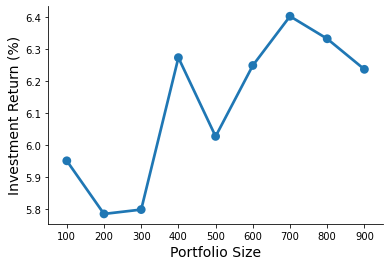

In [ ]:
## Note - this will only work for the 2015 dataset - 2012 sensitivity is at the end of section 4
result_sensitivity = []

## Vary the portfolio size from 100 to 1000
for num_loans in list(range(100,1000,100)):
    reg_0 = test_investments(data_dict15_strat, regressor = return_regressor_separate, classifier = default_classifier15, 
                            strategy = 'Two-stage', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_Hybrid']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(100,1000,100))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()

## Step 7. Save the models in one file.

In [ ]:
# save all time-consuming models in one dict_ 
# models_to_save['reg_rf13'] = reg_rf13
# models_to_save['reg_rf07'] = reg_rf07
# ... etc.

In [ ]:
## os.path.abspath(os.getcwd()) # get current directory
#filename = '/Users/su.jia/Box/LendingClub BigData2018/Su/saved_models/week4_saved_models'

path = root_dir + "/saved_models/week4_saved_models"   

outfile = open(path,'wb')
pickle.dump(models_to_save, outfile)
outfile.close()